# Age from face
Predict age of a person from an image of their face

### Project Repo 
https://github.com/buckcri/age-from-face

## Participants:
Oskar Lachnit, Florian Diedrich, Nils-Christian Buck

### Course and Semester
Deep Learning from Scratch, WiSe2122

### License
Not yet decided

---

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [2]:
#NB: Deleted folders for age >93 because there were fee files, but gaps (e.g. no 94 old persons)
#Afterwards class label is equal to index in prediction array
data_dir = "../data/face_age"

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
batch_size = 32

#Fix seed to achieve determinism
fixed_seed = 42

#10% of data reserved for validation set
validation_split=0.1

#Load both training and validation set. Sets are shuffled by default
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=fixed_seed,
  image_size=(100, 100),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=fixed_seed,
  image_size=(100, 100),
  batch_size=batch_size)


Found 9778 files belonging to 99 classes.
Using 8801 files for training.


2022-01-07 16:49:28.733033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 9778 files belonging to 99 classes.
Using 977 files for validation.


In [ ]:
#Show one random image from dataset, including label

example_batch = train_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

example_image = x[0]
example_label = y[0]

plt.imshow(example_image.numpy().astype("uint8"))
plt.title(example_label.numpy())
plt.axis("off")
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


In [ ]:
#Count the number of examples for each label
from collections import defaultdict

age_dist = defaultdict(int)

for x_batch,y_batch in train_ds.as_numpy_iterator():
   for i in range(len(y_batch)):
       age_dist[y_batch[i]] += 1


In [ ]:
#Plot above count
plt.bar(list(age_dist.keys()), age_dist.values())
plt.xlabel('Age')
plt.ylabel('#Examples')
plt.show()

In [ ]:
#Number of distinct labels:
num_labels = len(list(age_dist.keys()))

print(num_labels)

In [ ]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
# There's one output class for each label.
# @see https://www.tensorflow.org/api_docs/python/tf/keras/layers

num_classes = num_labels

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

In [ ]:
#Train model

epochs = 2 # 50 # (50 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print(model.summary())

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plt.plot(num_epochs, accuracy, label='Accuracy Train')
plt.plot(num_epochs, val_accuracy, label='Accuracy Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation accuracy')
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(num_epochs, loss, label='Loss Train')
plt.plot(num_epochs, val_loss, label='Loss Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation loss')
plt.show()

In [ ]:
def mean_avg_top_k(predictions, k=5):
    """Returns the average of the top k (default: k=5) best predictions' index (index equals age in our case)    
    """
    pred_index_list=sorted(((value, key) for (key,value) in enumerate(predictions[0])), reverse=True)
    sorted_index_pred_list=list([(key,value) for value,key in pred_index_list])

    avg = 0
    for i in range(k):
        key, value = sorted_index_pred_list[i]
        avg+=key
    avg/=k
    
    return avg

In [ ]:
#Show one random image from dataset, including label

example_batch = val_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    avg = mean_avg_top_k(predictions)
    plt.title(avg)
    plt.axis("off")
    plt.suptitle("Predicted (top k)")
    
plt.show()

In [ ]:
print("Predictions for last example:")
print(predictions)

Papers:

* S. N. Kohail:  
Using Artificial Neural Network for Human Age Estimation Based on Facial Images  
2012 International Conference on Innovations in Information Technology (IIT)  
https://www.inf.uni-hamburg.de/en/inst/ab/lt/people/alumni/sarah-kohail/kohail-age-estimation.pdf

* Z. Qawaqneh, A. Abu Mallouh & B. D. Barkana:  
Deep Convolutional Neural Network for Age Estimation based on VGG-Face Model  
https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf

* N. Hewahi, A. Olwan, N. Tubeel, S. El-Asar, Z. Abu-Sultan:  
Age Estimation based on Neural Networks using Face Features  
Journal of Emerging Trends in Computing and Information Sciences 1:2, October 2010  
https://www.researchgate.net/publication/47277288_Age_Estimation_based_on_Neural_Networks_using_Face_Features

* R. Rahadian & S. Suyanto:  
Deep Residual Neural Network for Age Classification with Face Image  
2019 International Seminar on Research of Information Technology and Intelligent Systems (ISRITI)  
https://ieeexplore.ieee.org/document/9034664

* M. M. Islam & J.-H. Baek:  
Deep Learning Based Real Age and Gender Estimation from Unconstrained Face Image towards Smart Store Customer Relationship Management  
Applied Sciences 2021, 11  
https://www.mdpi.com/2076-3417/11/10/4549/pdf

* A. Othmania, A. R. Taleb, H. Abdelkawy & A. Hadid:  
Age estimation from faces using deep learning: A comparative analysis  
Computer Vision and Image Understanding 196, July 2020  
https://www.sciencedirect.com/science/article/abs/pii/S1077314220300424

Additional links:

* https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2

In [ ]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
# There's one output class for each label.
# @see https://www.tensorflow.org/api_docs/python/tf/keras/layers

num_classes = num_labels

dropout_rate = 0.25

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

In [ ]:
#Train model

epochs = 2 # 60 # (60 is the desired value, 1 is just for faster testing)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print(model.summary())

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plt.plot(num_epochs, accuracy, label='Accuracy Train')
plt.plot(num_epochs, val_accuracy, label='Accuracy Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation accuracy')
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(num_epochs, loss, label='Loss Train')
plt.plot(num_epochs, val_loss, label='Loss Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation loss')
plt.show()

In [ ]:
#Show one random image from dataset, including label

example_batch = val_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    avg = mean_avg_top_k(predictions)
    plt.title(avg)
    plt.axis("off")
    plt.suptitle("Predicted (top k)")
    
plt.show()

In [ ]:
#Number of years to group together
age_grouping = 10

def label_group_mapping(x, y):
    return x, y//age_grouping

train_ds_grouped = train_ds.map(label_group_mapping)
val_ds_grouped = val_ds.map(label_group_mapping)

In [ ]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.

num_classes = num_labels//age_grouping
if ((num_labels % age_grouping) != 0):
    num_classes+=1

print(f"Grouped {num_labels} labels to {num_classes} classes with stride {age_grouping}.")

dropout_rate = 0.1

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

In [ ]:
#Train model

epochs = 2 # 30 # (30 is the desired value, 2 is just for faster testing)

history = model.fit(
  train_ds_grouped,
  validation_data=val_ds_grouped,
  epochs=epochs
)

print(model.summary())

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

num_epochs = range(len(accuracy))

plt.plot(num_epochs, accuracy, label='Accuracy Train')
plt.plot(num_epochs, val_accuracy, label='Accuracy Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation accuracy')
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(num_epochs, loss, label='Loss Train')
plt.plot(num_epochs, val_loss, label='Loss Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation loss')
plt.show()

In [ ]:
def to_grouped_age_range(age_class):
    lower_bound = age_class*age_grouping
    upper_bound = ((age_class+1)*age_grouping)-1
    return "{} ({}-{})".format(age_class, lower_bound, upper_bound)

In [ ]:
#Show one random image from dataset, including label

example_batch = val_ds_grouped.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(to_grouped_age_range(y[i].numpy()))
    #plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    plt.title(to_grouped_age_range(best_prediction))
    #lt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

In [ ]:
print("Predictions for last example:")
print(predictions)
print(best_prediction)

# Single Value Output Test

In [5]:
#Normalize life to a supposed lifespan of 100 years

def label_age_normalization(x, y):
    return x, tf.cast(y, tf.float32) / 100.0

train_ds_age_normalized = train_ds.map(label_age_normalization)
val_ds_age_normalized = val_ds.map(label_age_normalization)

In [35]:
dropout_rate = 0.1

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation='relu')
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer='adam',
  loss=tf.losses.MeanSquaredError(),
  metrics=['mean_squared_error'])

In [36]:
#Train model

epochs = 2 # 30 # (30 is the desired value, 1 is just for faster testing)

history = model.fit(
  train_ds_age_normalized,
  validation_data=val_ds_age_normalized,
  epochs=epochs
)

print(model.summary())

Epoch 1/2
276/276 [==============================] - 83s 286ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1038 - val_mean_squared_error: 0.1038
Epoch 2/2
276/276 [==============================] - 79s 285ms/step - loss: 0.0716 - mean_squared_error: 0.0716 - val_loss: 0.0847 - val_mean_squared_error: 0.0847
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 30000)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               15360512  
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                        

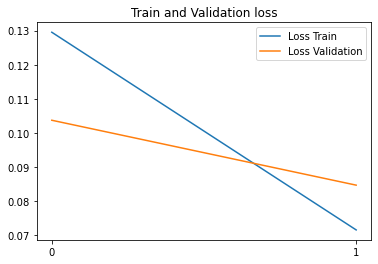

In [37]:
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']



# plt.plot(num_epochs, accuracy, label='Accuracy Train')
# plt.plot(num_epochs, val_accuracy, label='Accuracy Validation')
# plt.legend(loc=0)
# plt.xticks(num_epochs)
# plt.title('Train and Validation accuracy')
# plt.show()


loss = history.history['loss']
num_epochs = range(len(loss))
val_loss = history.history['val_loss']

plt.plot(num_epochs, loss, label='Loss Train')
plt.plot(num_epochs, val_loss, label='Loss Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation loss')
plt.show()

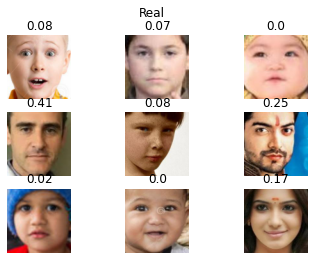

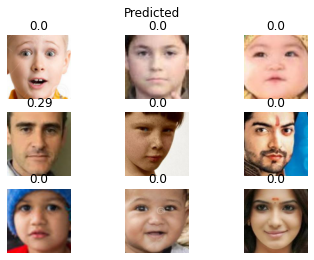

In [38]:
#Show one random image from dataset, including label

example_batch = val_ds_age_normalized.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(round(y[i].numpy(), 2))
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    # best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(round(predictions[0][0], 2))
    plt.axis("off")
    plt.suptitle("Predicted")
    
plt.show()

# Interaction

In [39]:
#Define helper function for showing picture and title, setup constants

from IPython.display import clear_output

example_age_prompt = "Let's Guess the age!"
keyboard_prompt = "Please press return."

def show_picture(picture, title):
    plt.imshow(picture.numpy().astype("uint8"))
    plt.title(title)
    plt.axis("off")
    plt.show()

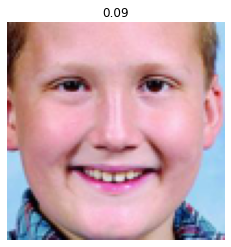

In [41]:
#Select one random image from dataset and generate prediction; on execution, every prompt for pressing return
#must be met, otherwise the cell does not terminate and cannot be restarted properly

example_batch = val_ds_age_normalized.take(1)

random_x,random_y = iter(example_batch).get_next()

example_image = random_x[0]
example_age_real = round(random_y[0].numpy(), 2)
example_age_predicted = round(model.predict(np.expand_dims(example_image, axis=0))[0][0], 2)

clear_output(wait = True)
show_picture(example_image, example_age_prompt)    #Show image with prompt
input(keyboard_prompt)

clear_output(wait = True)
show_picture(example_image, example_age_predicted) #Show image with predicted age
input(keyboard_prompt)

clear_output(wait = True)
show_picture(example_image, example_age_real)      #Show image with real age